In [2]:
import torch
from PIL import Image
from data_fetcher import (
    get_padded_image,
    get_line,
    extract_patch,
    get_line_data,
    extract_patches,
)
import matplotlib.pyplot as plt
from type_tree import TypeTree
import einops
import numpy as np

In [13]:
tt = TypeTree()

### Image rotation is easy

In [3]:
image_path = "./juneau2k.jpg"
image = Image.open(image_path)

rotated_image = image.rotate(90, expand=True)
rotated_image.save("juneau2k_90.jpg")

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
# Second attempt at image rotation but with matrices
def rotate_and_flip_image(image, angle=0, flip=False):
    if flip:
        image = image.flip(-1)

    if angle == 0:
        return image
    elif angle == 90:
        return image.transpose(-1, -2).flip(-1)
    elif angle == 180:
        return image.flip(-1).flip(-2)
    elif angle == 270:
        return image.flip(-1).transpose(-1, -2)
    else:
        raise ValueError("Unsupported angle. Supported values are 0, 90, 180, 270.")

In [81]:
tt(get_line_data([0], split=False))

list: 1371
    |__tuple
        |__Tensor (dtype: torch.float64)
        |   |__dim_0 (2)
        |   |__dim_1 (2)
        |__Tensor (dtype: torch.float64)
            |__dim_0 (2)


### Coordinate rotation is more complex

In [39]:
def rotate_and_flip_coordinates(coords, angle=0, flip=False):
    angle = np.radians(angle)
    x = coords[0]
    y = coords[1]
    if flip:
        x = x * -1
    x1 = x * np.cos(angle) - y * np.sin(angle)
    y1 = x * np.sin(angle) - y * np.cos(angle)
    return torch.stack([x1, y1])

In [40]:
def to_im(patch):
    return einops.rearrange(patch, "c h w -> h w c")


def numpy(v):
    return v.detach().cpu().numpy()

In [34]:
padding = 0
rot_image = get_padded_image("./juneau2k_90.jpg", padding).to("cuda")
image = get_padded_image("./juneau2k.jpg", padding).to("cuda")

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [41]:
line = get_line(0)

In [42]:
rot_line = rotate_and_flip_coordinates(line[0], 90)

In [45]:
print(line[0])
print(rot_line[0])

tensor([4447.0476, 2554.6568], dtype=torch.float64)
tensor(-2554.6568, dtype=torch.float64)


In [50]:
normal_patch = extract_patch(image, line[0], 20, padding, reshape=False)
rot_patch = extract_patch(image, line[0], 20, padding, reshape=False)

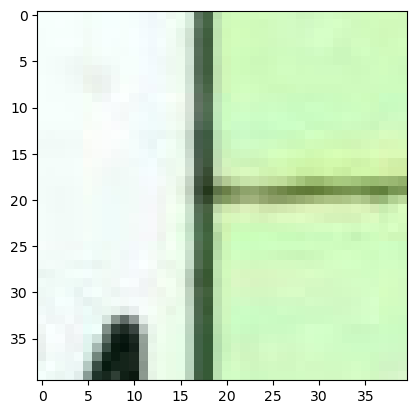

In [51]:
plt.imshow(numpy(to_im(normal_patch)))

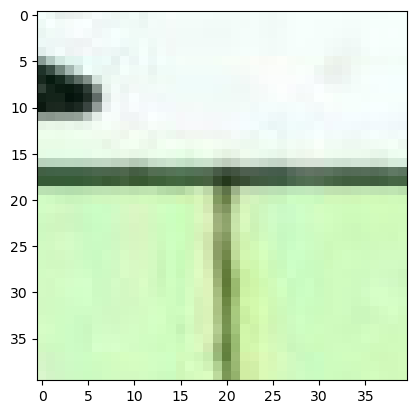

In [53]:
jplt.imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 90))))

In [64]:
tt(normal_patch)
tt(rotate_and_flip_coordinates(normal_patch))

Tensor (dtype: torch.float32)
    |__dim_0 (3)
    |__dim_1 (40)
    |__dim_2 (40)
Tensor (dtype: torch.float32)
    |__dim_0 (2)
    |__dim_1 (40)
    |__dim_2 (40)


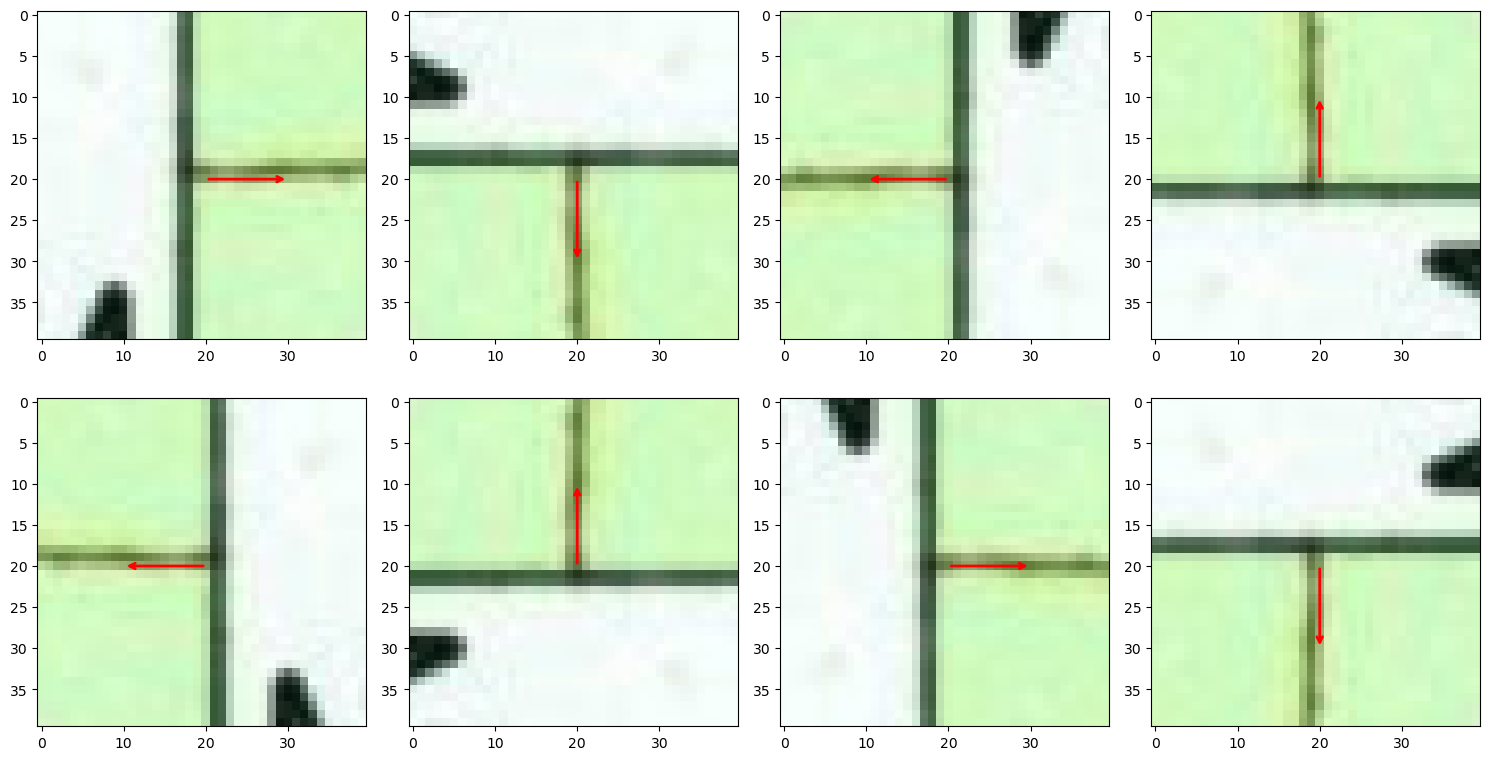

In [78]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].imshow(numpy(to_im(rotate_and_flip_image(normal_patch))))
axs[0, 1].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 90))))
axs[0, 2].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 180))))
axs[0, 3].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 270))))
axs[1, 0].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 0, True))))
axs[1, 1].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 90, flip=True))))
axs[1, 2].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 180, flip=True))))
axs[1, 3].imshow(numpy(to_im(rotate_and_flip_image(normal_patch, 270, flip=True))))
base_arrow = torch.tensor([10, 0])
base_point = torch.tensor([20, 20])
arrows = [
    rotate_and_flip_coordinates(base_arrow, 0),
    rotate_and_flip_coordinates(base_arrow, 90),
    rotate_and_flip_coordinates(base_arrow, 180),
    rotate_and_flip_coordinates(base_arrow, 270),
    rotate_and_flip_coordinates(base_arrow, 0, True),
    rotate_and_flip_coordinates(base_arrow, 90, True),
    rotate_and_flip_coordinates(base_arrow, 180, True),
    rotate_and_flip_coordinates(base_arrow, 270, True),
]
for i, ax in enumerate(axs.flatten()):
    arrowprops = dict(arrowstyle="->", linewidth=2, color="red")
    ax.annotate("", arrows[i] + base_point, base_point, arrowprops=arrowprops)

plt.tight_layout()
plt.show()

In [69]:
arrows[i]

NameError: name 'arrows' is not defined